In [1]:
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import sklearn
import matplotlib.pyplot as plt

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
!git clone https://github.com/spyysalo/tiny-nemotron-cc-sample/

fatal: destination path 'tiny-nemotron-cc-sample' already exists and is not an empty directory.


In [3]:
!du -h tiny-nemotron-cc-sample/data/*

2.3M	tiny-nemotron-cc-sample/data/high-actual.jsonl
700K	tiny-nemotron-cc-sample/data/high-distill.jsonl
2.0M	tiny-nemotron-cc-sample/data/high-diverse_qa_pairs.jsonl
1.3M	tiny-nemotron-cc-sample/data/high-extract_knowledge.jsonl
864K	tiny-nemotron-cc-sample/data/high-knowledge_list.jsonl
1.5M	tiny-nemotron-cc-sample/data/high-wrap_medium.jsonl
1.6M	tiny-nemotron-cc-sample/data/low-actual.jsonl
1.4M	tiny-nemotron-cc-sample/data/low-wrap_medium.jsonl
7.5M	tiny-nemotron-cc-sample/data/medium-actual.jsonl
1.6M	tiny-nemotron-cc-sample/data/medium-high-actual.jsonl
3.3M	tiny-nemotron-cc-sample/data/medium-low-actual.jsonl


In [4]:
score_files = {
    5: "tiny-nemotron-cc-sample/data/high-actual.jsonl",
    4: "tiny-nemotron-cc-sample/data/medium-high-actual.jsonl",
    3: "tiny-nemotron-cc-sample/data/medium-actual.jsonl",    
    2: "tiny-nemotron-cc-sample/data/medium-low-actual.jsonl",
    1: "tiny-nemotron-cc-sample/data/low-actual.jsonl",
}
dfs = []

for score, filename in score_files.items():
    df = pd.read_json(filename, lines=True)
    df["score"] = score
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.head()

,text,language,warc_record_id,url,score
0,"In the autumn, falling leaves and dried-out we...",eng,ae74c0dc-785d-4c76-82e8-61ab46313f15,http://www.wcax.com/story/15369365/is-your-dog...,5
1,One of the 12 constellations introduced at the...,eng,f41502ad-88f3-4ba9-96ea-04d301175c19,http://www.ianridpath.com/startales/grus.htm,5
2,pictures,eng,0f3462fe-8fa1-47bf-8396-acb92e997f95,http://www.itshareware.com/catlist-code_157-st...,5
3,Avoid Frying When Flying: Eliminate Ionizing R...,eng,f42b4f0e-eb41-4c0a-b7d3-c615780be0f0,http://www.naturalnews.com/030425_radiation_fl...,5
4,Posts Tagged pacho galan\n\nNothing sexier in ...,eng,dcf4b10d-db43-4e6b-b7ed-d0a037f7a760,http://generationbass.com/tag/pacho-galan/,5


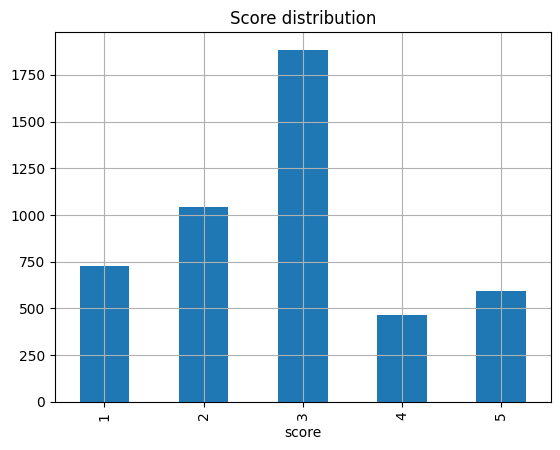

In [5]:
ax = df.score.value_counts().sort_index().plot(kind="bar")
ax.set_title("Score distribution")
ax.grid()

In [6]:
!python --version

Python 3.12.9


In [33]:
def show_given_record(i: int):
    print(f"-----{i}------")
    print(f'{df.loc[i, "text"]}')
    print(f'{df.loc[i, "url"]}')
    print(f'Score: {df.loc[i, "score"]}')

interact(show_given_record)

interactive(children=(IntText(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_given_record(i: int)>

In [8]:
# count the number of tokens
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

# Function to count tokens
def count_tokens(text):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return len(tokens)

# Apply the function to create a new column with token counts
df['token_count'] = df['text'].apply(count_tokens)

# View the first few rows with token counts
print(df[['text', 'token_count']].head())

# Get total tokens across all rows
total_tokens = df['token_count'].sum()
print(f"Total tokens: {total_tokens}")

                                                text  token_count
0  In the autumn, falling leaves and dried-out we...          257
1  One of the 12 constellations introduced at the...          410
2                                           pictures            1
3  Avoid Frying When Flying: Eliminate Ionizing R...          707
4  Posts Tagged pacho galan\n\nNothing sexier in ...           93
Total tokens: 3450034


In [9]:
total_tokens = df.loc[df.token_count < 2000, 'token_count'].sum()
print(f"Total tokens of documents with <2K tokens: {total_tokens}")

Total tokens of documents with <2K tokens: 2096942


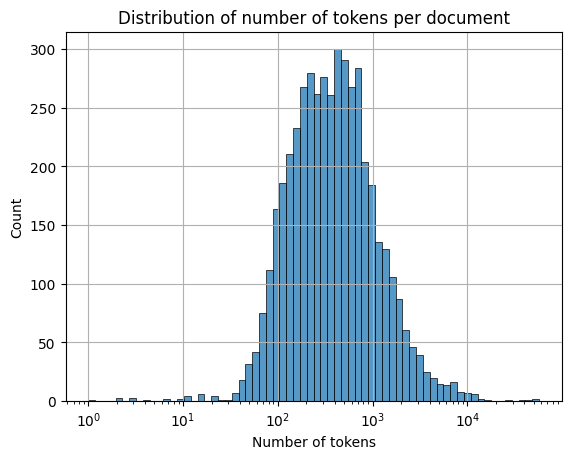

In [10]:
ax = sns.histplot(df["token_count"], log_scale=True)
ax.set_title("Distribution of number of tokens per document")
ax.set_xlabel("Number of tokens")
ax.grid()

In [11]:
price_per_1M_token = 0.18  # 8B-turbo
#price_per_1M_token = 0.88  # 70B-turbo
print(f"Expected price: {total_tokens * price_per_1M_token * 1e-6}")

Expected price: 0.37744955999999996


# Test document quality judge

In [12]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_together import ChatTogether
from langchain_community.cache import SQLiteCache
from langchain_core.globals import set_llm_cache

set_llm_cache(SQLiteCache(database_path=".langchain.db"))

model = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
chat_model = ChatTogether(model=model)

In [13]:
# Prompt from SmolLM2 https://arxiv.org/pdf/2502.02737 Appendix C.3
system_template_smollm2 = "You are a smart assistant helping to measure the quality of text."
prompt_analysis_smollm2 = '''\
Evaluate the following text extract for its potential usefulness for studying mathematics up to high school and early undergraduate levels. Use the following 5-point scoring system described below. Points are accumulated based on the satisfaction of each criterion:

- Add 1 point if the extract contains some mathematical content, even if it's not very useful for studying, or if it contains non-academic content such as advertisements and generated pages for converting weight and currencies.
- Add another point if the extract touches on mathematical topics, even if it's poorly written if it's too complex such as an academic paper that is too advanced.
- Award a third point if the extract demonstrates problem solving or logical reasoning in a mathematical context, even if it lacks step-by-step explanations.
- Grant a fourth point if the extract is at an appropriate level (up to high school and early undergraduate levels) and contains clear mathematical deductions and step-by-step solutions to mathematical problems. It should be similar to a chapter from a textbook or a tutorial.
- Give a fifth point if the extract is outstanding in its educational value for teaching and studying mathematics in middle school and high school. It should include very detailed and easy to follow explanations.

Question-answer formats (e.g., from educational websites or forums) are acceptable if they meet the criteria.

The text extract:
{prompt}

After examining the extract:
- Briefly justify your total score, up to 100 words.
- Conclude with the score using the format: Final score: <total points>.
'''
print(prompt_analysis_smollm2)

Evaluate the following text extract for its potential usefulness for studying mathematics up to high school and early undergraduate levels. Use the following 5-point scoring system described below. Points are accumulated based on the satisfaction of each criterion:

- Add 1 point if the extract contains some mathematical content, even if it's not very useful for studying, or if it contains non-academic content such as advertisements and generated pages for converting weight and currencies.
- Add another point if the extract touches on mathematical topics, even if it's poorly written if it's too complex such as an academic paper that is too advanced.
- Award a third point if the extract demonstrates problem solving or logical reasoning in a mathematical context, even if it lacks step-by-step explanations.
- Grant a fourth point if the extract is at an appropriate level (up to high school and early undergraduate levels) and contains clear mathematical deductions and step-by-step solution

In [14]:
prompt_template_smollm2 = ChatPromptTemplate.from_messages([
    ("system", system_template_smollm2), 
    ("user", prompt_analysis_smollm2),
])
#print(prompt.messages[1].content)

In [15]:
system_template_fwedu = "You are a smart assistant helping to measure the quality of text."
prompt_analysis_fwedu = '''\
Below is an extract from a web page. Evaluate whether the page has a high educational value and could be useful in an educational setting for teaching from primary school to grade school levels using the additive 5-point scoring system described below. Points are accumulated based on the satisfaction of each criterion:
• Add 1 point if the extract provides some basic information relevant to educational topics, even if it includes some irrelevant or non-academic content like advertisements and promotional material.
• Add another point if the extract addresses certain elements pertinent to education but does not align closely with educational standards. It might mix educational content with non-educational material, offering a superficial overview of potentially useful topics, or presenting information in a disorganized manner and incoherent writing style.
• Award a third point if the extract is appropriate for educational use and introduces key concepts relevant to school curricula. It is coherent though it may not be comprehensive or could include some extraneous information. It may resemble an introductory section of a textbook or a basic tutorial that is suitable for learning but has notable limitations like treating concepts that are too complex for grade school students.
• Grant a fourth point if the extract highly relevant and beneficial for educational purposes for a level not higher than grade school, exhibiting a clear and consistent writing style. It could be similar to a chapter from a textbook or a tutorial, offering substantial educational content, including exercises and solutions, with minimal irrelevant information, and the concepts aren't too advanced for grade school students. The content is coherent, focused, and valuable for structured learning.
• Bestow a fifth point if the extract is outstanding in its educational value, perfectly suited for teaching either at primary school or grade school. It follows detailed reasoning, the writing style is easy to follow and offers profound and thorough insights into the subject matter, devoid of any non-educational or complex content.

The extract: {prompt}.

After examining the extract:
• Briefly justify your total score, up to 100 words.
• Conclude with the score using the format: "Educational score: <total points>"
'''
prompt_template_fwedu = ChatPromptTemplate.from_messages([
    ("system", system_template_fwedu), 
    ("user", prompt_analysis_fwedu),
])

print(prompt_analysis_fwedu)

Below is an extract from a web page. Evaluate whether the page has a high educational value and could be useful in an educational setting for teaching from primary school to grade school levels using the additive 5-point scoring system described below. Points are accumulated based on the satisfaction of each criterion:
• Add 1 point if the extract provides some basic information relevant to educational topics, even if it includes some irrelevant or non-academic content like advertisements and promotional material.
• Add another point if the extract addresses certain elements pertinent to education but does not align closely with educational standards. It might mix educational content with non-educational material, offering a superficial overview of potentially useful topics, or presenting information in a disorganized manner and incoherent writing style.
• Award a third point if the extract is appropriate for educational use and introduces key concepts relevant to school curricula. It 

In [16]:
#prompt_example = prompt_template.invoke({"prompt": "The European Union decided to fund a large project to train an LLM."})
#print(prompt_example.messages[1].content)

In [17]:
text = "The European Union decided to fund a large project to train an LLM."
prompt_templated = prompt_template_fwedu.invoke({"prompt": text})
res = chat_model.invoke(prompt_templated)
completion = res.content
print(completion)
print(f'\n---\nText:{text}')

Justification: 
The extract provides some basic information relevant to educational topics, specifically mentioning a project related to LLM (Large Language Model) training. However, it lacks context and details about the project, making it difficult to assess its educational value. The extract does not align closely with educational standards, and it does not introduce key concepts relevant to school curricula. It is also unclear if the content is suitable for grade school students. The writing style is concise but lacks coherence and focus.

Total score: 1 point

Educational score: 1

---
Text:The European Union decided to fund a large project to train an LLM.


In [18]:
# Run the scorer on a given document
i = 1
prompt_templated = prompt_template_smollm2.invoke({"prompt": df.loc[i, "text"]})
res = chat_model.invoke(prompt_templated)
completion = res.content
print(completion)
print(f'\n---\nText:{df.loc[i, "text"]}')

After examining the text extract, I found that it contains some mathematical content, specifically the mention of the brightest star's magnitude (second magnitude) and the use of astronomical coordinates (e.g., Piscis Austrinus). However, the extract does not touch on mathematical topics relevant to high school and early undergraduate levels. It also does not demonstrate problem-solving or logical reasoning in a mathematical context. The extract is written in a historical and descriptive style, focusing on the constellation Grus and its associations. It does not contain clear mathematical deductions or step-by-step solutions to mathematical problems.

The extract is not at an appropriate level for studying mathematics up to high school and early undergraduate levels, and it lacks detailed explanations. However, it does provide some interesting historical and cultural information about the constellation Grus.

Final score: 1.

---
Text:One of the 12 constellations introduced at the end 

In [20]:
import re

class Scorer:
    def score(text: str) -> int:
        return 1

In [21]:
def extract_score_smollm2(completion: str):
    # Look for "Final score:" followed by optional whitespace and an integer
    match = re.search(r'Final score:\s*(\d+)', completion)    
    if match:
        return int(np.clip(int(match.group(1)), 0, 5))
    else:
        return None
        
class ScorerSmolLM2:
    def __init__(self, model: str):
        self.model = model
        self.prompt_template = prompt_template_smollm2
        self.extract_score = extract_score_smollm2
        self.chat_model = ChatTogether(model=model)
        
    def score_batch(self, texts: list[str], verbose: bool = False):
        prompt_templated = [self.prompt_template.invoke({"prompt": text}) for text in texts]
        completions = self.chat_model.batch(prompt_templated)        
        scores = [self.extract_score(completion.content) for completion in completions]           
        if verbose:
            for text, completion, score in zip(texts, completions, scores):
                print(f"Input text:\n{text}\n--")
                print(f"Completion:\n{completion.content}\n--")
                print(f"Score: {score}")
        return scores
    
    def __str__(self):
        model = self.model.split("/")[1]
        return f"SmolLM2-{model}"

ScorerSmolLM2(model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo").score_batch([text], verbose=True)

Input text:
The European Union decided to fund a large project to train an LLM.
--
Completion:
After examining the text extract, I found that it contains some non-academic content (1 point) as it appears to be a snippet of a news article or a discussion about a project. However, it does not touch on any mathematical topics (0 points), demonstrate problem solving or logical reasoning (0 points), contain clear mathematical deductions and step-by-step solutions (0 points), or provide detailed and easy-to-follow explanations (0 points).

Justification: The text extract is not related to mathematics and does not provide any educational value for studying mathematics up to high school and early undergraduate levels.

Final score: 1.
--
Score: 1


[1]

In [22]:
def extract_score_fwedu(completion: str):
    # Look for "Final score:" followed by optional whitespace and an integer
    match = re.search(r'Educational score:\s*(\d+)', completion)    
    if match:
        return int(np.clip(int(match.group(1)), 0, 5))
    else:
        return None
        
class ScorerSmolFWEDU(ScorerSmolLM2):
    def __init__(self, model: str):
        super(ScorerSmolFWEDU, self).__init__(model)        
        self.prompt_template = prompt_template_fwedu
        self.extract_score = extract_score_fwedu

    def __str__(self):
        model = self.model.split("/")[1]
        return f"FWEDU-{model}"

ScorerSmolFWEDU(model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo").score_batch([text], verbose=True)

Input text:
The European Union decided to fund a large project to train an LLM.
--
Completion:
Justification: 
The extract provides some basic information relevant to educational topics, specifically mentioning a project related to LLM (Large Language Model) training. However, it lacks context and details about the project, making it difficult to assess its educational value. The extract does not align closely with educational standards, and it does not introduce key concepts relevant to school curricula. It is also unclear if the content is suitable for grade school students. The writing style is concise but lacks coherence and focus.

Total score: 1 point

Educational score: 1
--
Score: 1


[1]

# Run document quality judge on corpus

In [23]:
from collections import defaultdict
import random
random.seed(0)

df_shuffle = df.sample(frac=1, replace=False, random_state=0).copy()

n_draws = 100
score = 5
models = [
    "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
]

# For every score:
# 1) generate subsample dataframe with score 
# 2) call LLM scorer to get completion
# 3) parse values and add to dataframe
df_scores_models = defaultdict(list)

scorers = [
    scorer_cls(model)
    for model in models
    for scorer_cls in [ScorerSmolFWEDU, ScorerSmolLM2]
]

for score in [5, 4, 3, 2, 1]: 
    df_score = df_shuffle[(df_shuffle.score == score) & (df_shuffle.token_count < 2000)]
    df_score = df_score.head(n_draws).copy()

    df_nemotron = df_score.loc[:, ["text", "score"]].copy()
    df_nemotron["model"] = "Nemotron-cc"
    df_nemotron["scorer"] = "Nemotron-cc"

    df_scores_models["Nemotron-cc"].append(df_nemotron)

    for scorer in scorers:    
        print(f"Eval score {score} with {len(df_score)} samples and scorer {str(scorer)}.")
        scores = scorer.score_batch(df_score.loc[:, "text"].values.tolist())
        df_score["model"] = scorer.model
        df_score["score"] = scores
        df_score["scorer"] = str(scorer.__class__.__name__)
        df_scores_models[str(scorer)].append(df_score.loc[:, ["text", "model", "score", "scorer"]])


Eval score 5 with 100 samples and scorer FWEDU-Meta-Llama-3.1-8B-Instruct-Turbo.
Eval score 5 with 100 samples and scorer SmolLM2-Meta-Llama-3.1-8B-Instruct-Turbo.
Eval score 5 with 100 samples and scorer FWEDU-Meta-Llama-3.1-70B-Instruct-Turbo.
Eval score 5 with 100 samples and scorer SmolLM2-Meta-Llama-3.1-70B-Instruct-Turbo.
Eval score 4 with 100 samples and scorer FWEDU-Meta-Llama-3.1-8B-Instruct-Turbo.
Eval score 4 with 100 samples and scorer SmolLM2-Meta-Llama-3.1-8B-Instruct-Turbo.
Eval score 4 with 100 samples and scorer FWEDU-Meta-Llama-3.1-70B-Instruct-Turbo.
Eval score 4 with 100 samples and scorer SmolLM2-Meta-Llama-3.1-70B-Instruct-Turbo.
Eval score 3 with 100 samples and scorer FWEDU-Meta-Llama-3.1-8B-Instruct-Turbo.
Eval score 3 with 100 samples and scorer SmolLM2-Meta-Llama-3.1-8B-Instruct-Turbo.
Eval score 3 with 100 samples and scorer FWEDU-Meta-Llama-3.1-70B-Instruct-Turbo.
Eval score 3 with 100 samples and scorer SmolLM2-Meta-Llama-3.1-70B-Instruct-Turbo.
Eval score

In [24]:
df_all_scores = pd.concat([df for dfs in df_scores_models.values() for df in dfs], ignore_index=True)
len(df_all_scores)

2500

In [25]:
df_all_scores

,text,score,model,scorer
0,"In August, the Board of Regents amended the re...",5.0,Nemotron-cc,Nemotron-cc
1,"Vivek High School, Mohali, Book Set for Class ...",5.0,Nemotron-cc,Nemotron-cc
2,"2\n\nThe article on Nobel prizes, ""What does ...",5.0,Nemotron-cc,Nemotron-cc
3,AK Vs AK full Movie\n\nHelmed by Vikramaditya ...,5.0,Nemotron-cc,Nemotron-cc
4,Change is in your pocket\n\nThe Big Issue is a...,5.0,Nemotron-cc,Nemotron-cc
...,...,...,...,...
2495,"Monday, August 30, 2010\n\nCosmo has had this ...",0.0,meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo,ScorerSmolLM2
2496,"RILEY ENTERTAINMENT\n\nGROUP, INC.\n\nHome\n\n...",0.0,meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo,ScorerSmolLM2
2497,Glenn Alexander Hosts Cancer Benefit Pig Gig 2...,0.0,meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo,ScorerSmolLM2
2498,Search This Blog\n\nClash of the Tartans\n\nHa...,0.0,meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo,ScorerSmolLM2


In [26]:
# check correlation of different methods
df_all_scores.pivot_table(index="text", columns=['model', 'scorer'], values='score').corr()

model                                                        Nemotron-cc  \
scorer                                                       Nemotron-cc   
model                                        scorer                        
Nemotron-cc                                  Nemotron-cc        1.000000   
meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo ScorerSmolFWEDU    0.552931   
                                             ScorerSmolLM2      0.175627   
meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo  ScorerSmolFWEDU    0.514891   
                                             ScorerSmolLM2      0.205227   

model                                                        meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo  \
scorer                                                                                    ScorerSmolFWEDU   
model                                        scorer                                                         
Nemotron-cc                                  Nemotron-cc                                         0.552931   
meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo ScorerSmolFWEDU                                     1.000000   
                                             ScorerSmolLM2                                       0.258582   
meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo  ScorerSmolFWEDU                                     0.693139   
                                             ScorerSmolLM2                                       0.303695   

model                                                                       \
scorer                                                       ScorerSmolLM2   
model                                        scorer                          
Nemotron-cc                                  Nemotron-cc          0.175627   
meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo ScorerSmolFWEDU      0.258582   
                                             ScorerSmolLM2        1.000000   
meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo  ScorerSmolFWEDU      0.209630   
                                             ScorerSmolLM2        0.392429   

model                                                        meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo  \
scorer                                                                                   ScorerSmolFWEDU   
model                                        scorer                                                        
Nemotron-cc                                  Nemotron-cc                                        0.514891   
meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo ScorerSmolFWEDU                                    0.693139   
                                             ScorerSmolLM2                                      0.209630   
meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo  ScorerSmolFWEDU                                    1.000000   
                                             ScorerSmolLM2                                      0.282376   

model                                                                       
scorer                                                       ScorerSmolLM2  
model                                        scorer                         
Nemotron-cc                                  Nemotron-cc          0.205227  
meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo ScorerSmolFWEDU      0.303695  
                                             ScorerSmolLM2        0.392429  
meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo  ScorerSmolFWEDU      0.282376  
                                             ScorerSmolLM2        1.000000

In [27]:
# average scores of different methods, Nemotron-cc is much higher
df_all_scores.loc[:, ["model", "score", "scorer"]].groupby(["scorer", "model"]).mean()

score
scorer          model                                                 
Nemotron-cc     Nemotron-cc                                   3.000000
ScorerSmolFWEDU meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo  1.050000
                meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo   1.346232
ScorerSmolLM2   meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo  0.126000
                meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo   0.940000

Text(0.5, 0.98, 'Confusion matrix between different annotators')

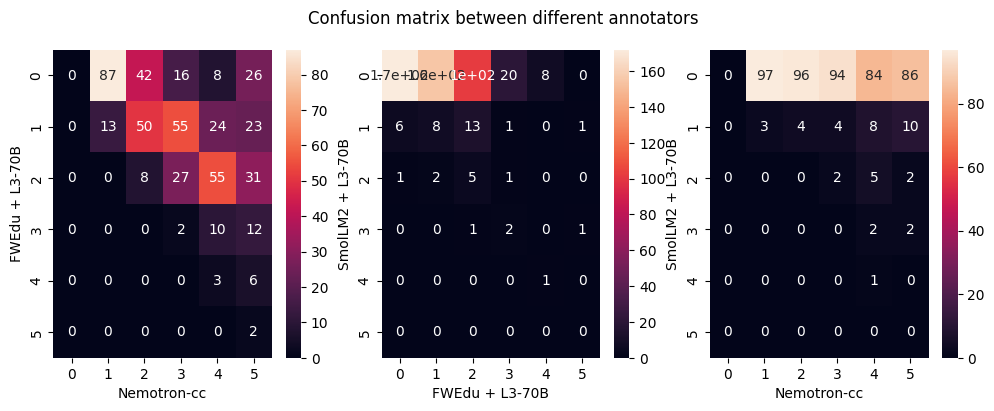

In [28]:
# Check confusion matrix between different annotators
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#ys = {
#    model: df_all_scores.loc[df_all_scores['model'] == model, "score"]
#    for model in ["Nemotron-cc"] + models
#}

ys = {
    "Nemotron-cc": df_all_scores.loc[df_all_scores['model'] == "Nemotron-cc", "score"],
    "FWEdu + L3-70B": df_all_scores.loc[(df_all_scores['scorer'] == "ScorerSmolFWEDU") & (df_all_scores['model'] == "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"), "score"],
    "SmolLM2 + L3-70B": df_all_scores.loc[(df_all_scores['scorer'] == "ScorerSmolLM2") & (df_all_scores['model'] == "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"), "score"],
}
model_ys = list(ys.keys())

ax = axes[0]
model_x = model_ys[0]
model_y = model_ys[1]
ax = sns.heatmap(sklearn.metrics.confusion_matrix(ys[model_x], ys[model_y]).T, annot=True, ax=ax)
ax.set_xlabel(model_x)
ax.set_ylabel(model_y)

ax = axes[1]
model_x = model_ys[1]
model_y = model_ys[2]
ax = sns.heatmap(sklearn.metrics.confusion_matrix(ys[model_x], ys[model_y]).T, annot=True, ax=ax)
ax.set_xlabel(model_x)
ax.set_ylabel(model_y)

ax = axes[2]
model_x = model_ys[0]
model_y = model_ys[2]
ax = sns.heatmap(sklearn.metrics.confusion_matrix(ys[model_x], ys[model_y]).T, annot=True, ax=ax)
ax.set_xlabel(model_x)
ax.set_ylabel(model_y)
fig.suptitle("Confusion matrix between different annotators")